In [40]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import warnings
warnings.filterwarnings('ignore')


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import numpy
import pandas
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense ,Dropout,BatchNormalization
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os

# Any results you write to the current directory are saved as output.

In [41]:
df=pd.read_csv("data/Admission_Predict_Ver1.1.csv")
#changing names because previous names are little bit confusing
df=df.rename(index=str, columns={"GRE Score": "GRE", "TOEFL Score": "TOEFL", "Chance of Admit ": "Admission_Chance"})
#we donot need serial number so its good to drop it because its just a number
df=df.drop("Serial No.",axis=1)
df.head(10)

GRE  TOEFL  University Rating  SOP  LOR   CGPA  Research  Admission_Chance
0  337    118                  4  4.5   4.5  9.65         1              0.92
1  324    107                  4  4.0   4.5  8.87         1              0.76
2  316    104                  3  3.0   3.5  8.00         1              0.72
3  322    110                  3  3.5   2.5  8.67         1              0.80
4  314    103                  2  2.0   3.0  8.21         0              0.65
5  330    115                  5  4.5   3.0  9.34         1              0.90
6  321    109                  3  3.0   4.0  8.20         1              0.75
7  308    101                  2  3.0   4.0  7.90         0              0.68
8  302    102                  1  2.0   1.5  8.00         0              0.50
9  323    108                  3  3.5   3.0  8.60         0              0.45

In [42]:
df.describe()

GRE       TOEFL  University Rating         SOP       LOR   \
count  500.000000  500.000000         500.000000  500.000000  500.00000   
mean   316.472000  107.192000           3.114000    3.374000    3.48400   
std     11.295148    6.081868           1.143512    0.991004    0.92545   
min    290.000000   92.000000           1.000000    1.000000    1.00000   
25%    308.000000  103.000000           2.000000    2.500000    3.00000   
50%    317.000000  107.000000           3.000000    3.500000    3.50000   
75%    325.000000  112.000000           4.000000    4.000000    4.00000   
max    340.000000  120.000000           5.000000    5.000000    5.00000   

             CGPA    Research  Admission_Chance  
count  500.000000  500.000000         500.00000  
mean     8.576440    0.560000           0.72174  
std      0.604813    0.496884           0.14114  
min      6.800000    0.000000           0.34000  
25%      8.127500    0.000000           0.63000  
50%      8.560000    1.000000           0.72000  
75%      9.040000    1.000000           0.82000  
max      9.920000    1.000000           0.97000

In [43]:
admit=np.asarray(df["Admission_Chance"])
len(np.unique(admit))
#we have 60 different values in the coloum [chance to predict]

61

In [44]:
df.shape

(500, 8)

#### Correlation
In statistics, the Pearson correlation coefficient, also referred to as Pearson's r, the Pearson product-moment correlation coefficient or the bivariate correlation, is a measure of the linear correlation between two variables X and Y. 

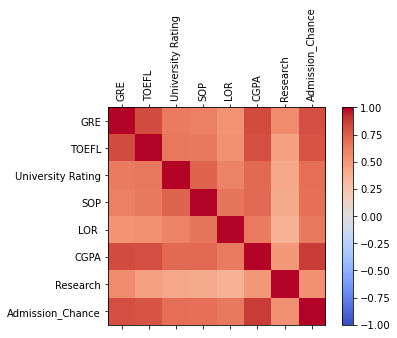

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
corr = df.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()

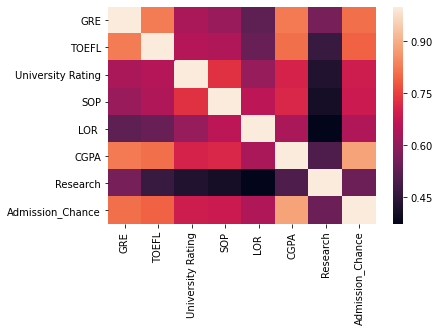

In [46]:
import seaborn as sns
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

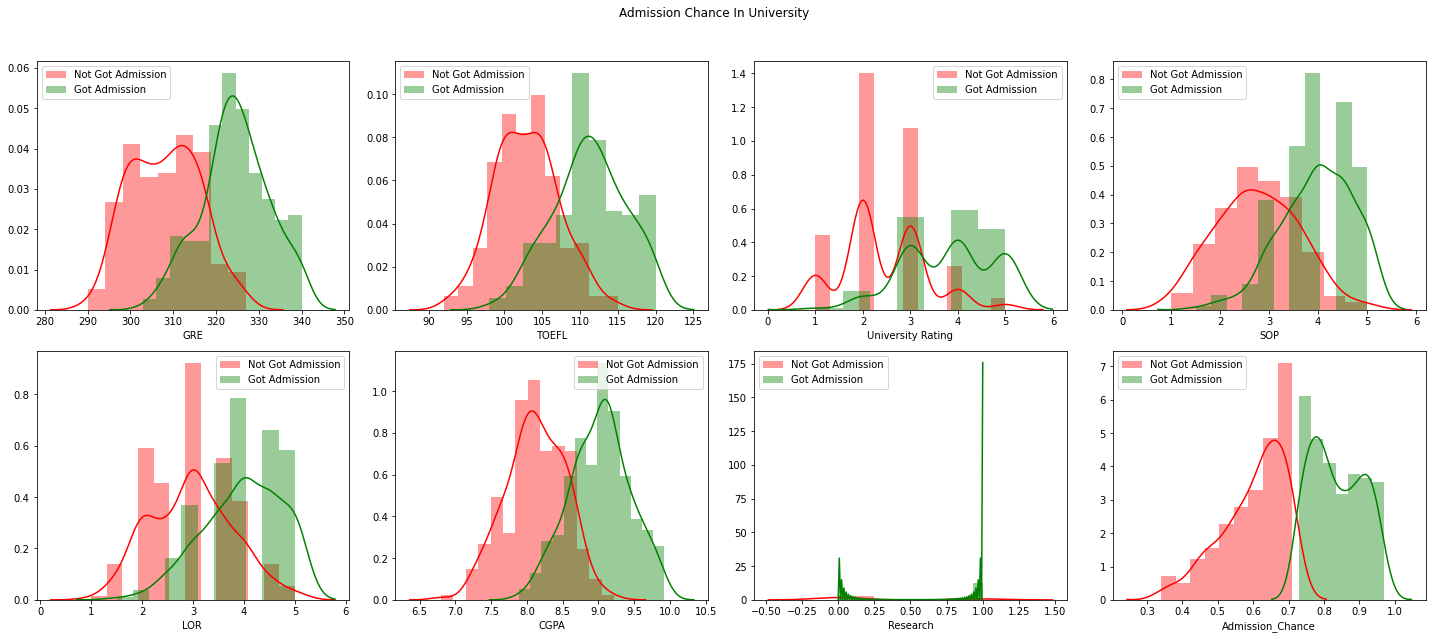

In [47]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in df.columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(df[i][df['Admission_Chance']<0.72], color='r', label = 'Not Got Admission')
    sns.distplot(df[i][df['Admission_Chance']>0.72], color='g', label = 'Got Admission')
    plt.legend(loc='best')
fig.suptitle('Admission Chance In University ')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

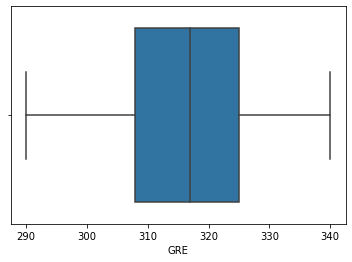

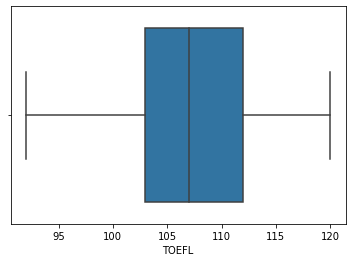

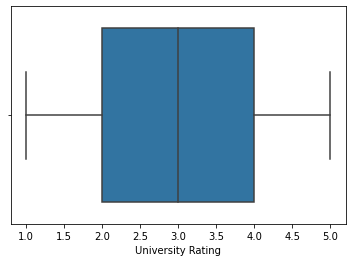

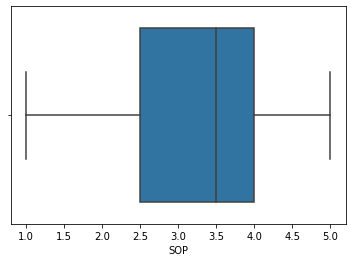

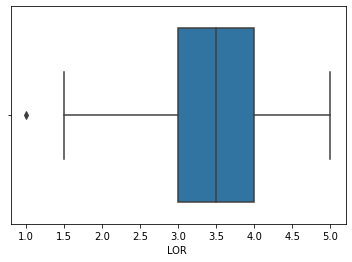

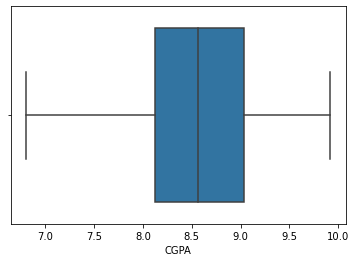

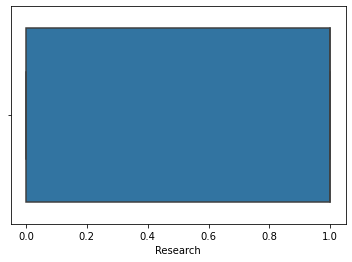

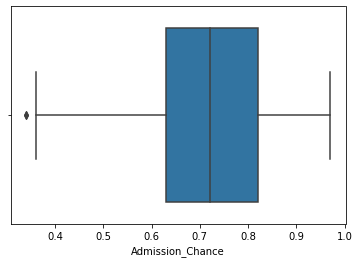

In [49]:
for column in df:
    plt.figure()
    sns.boxplot(x=df[column])

**thats good we have no outliers**

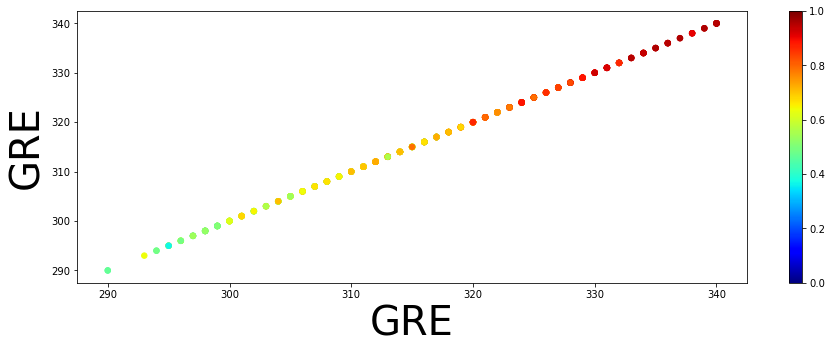

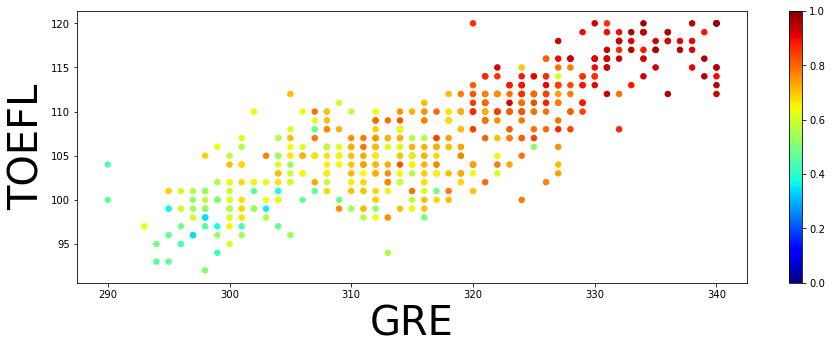

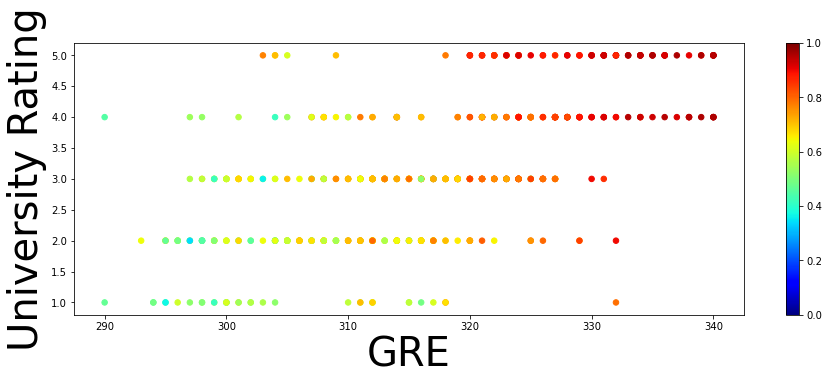

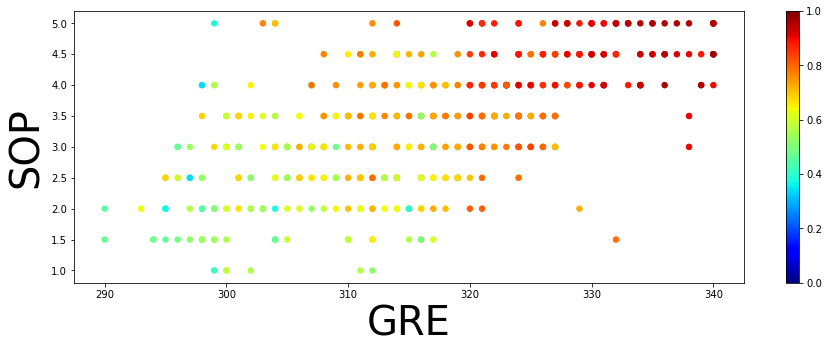

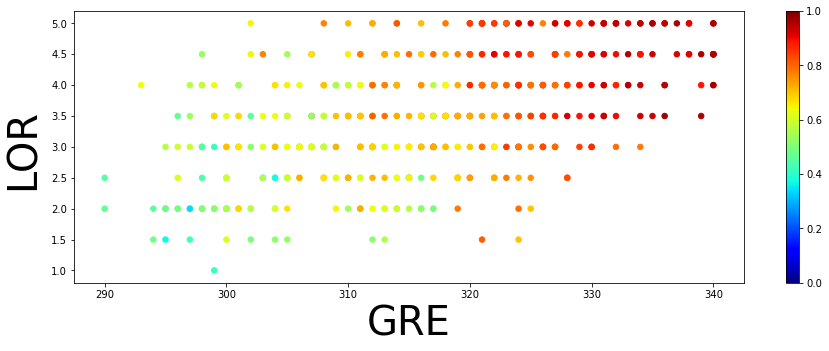

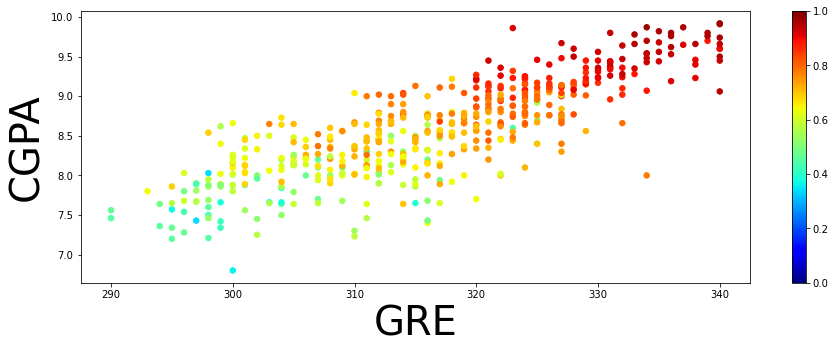

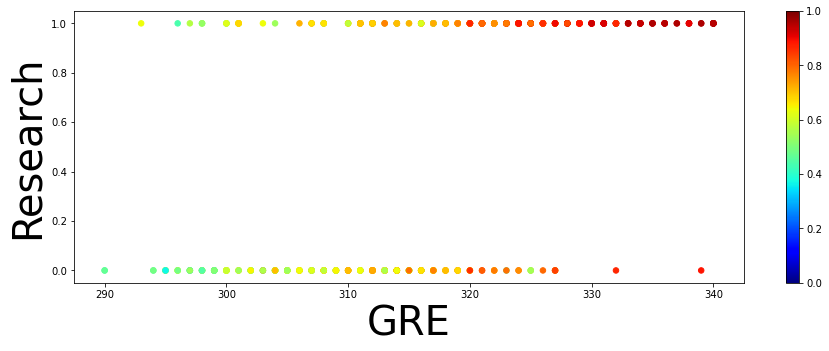

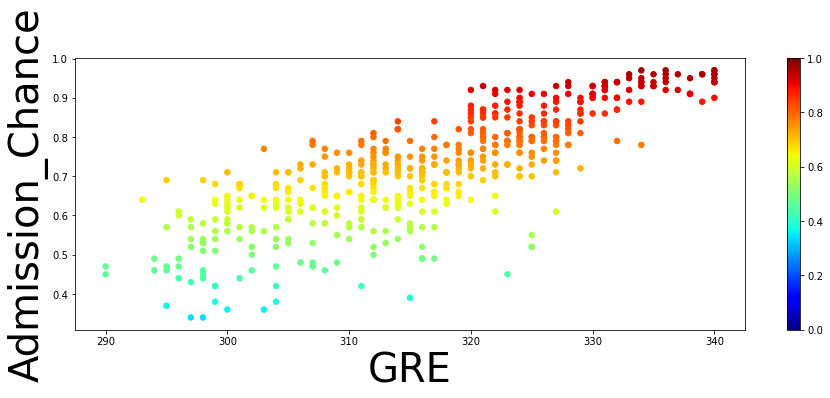

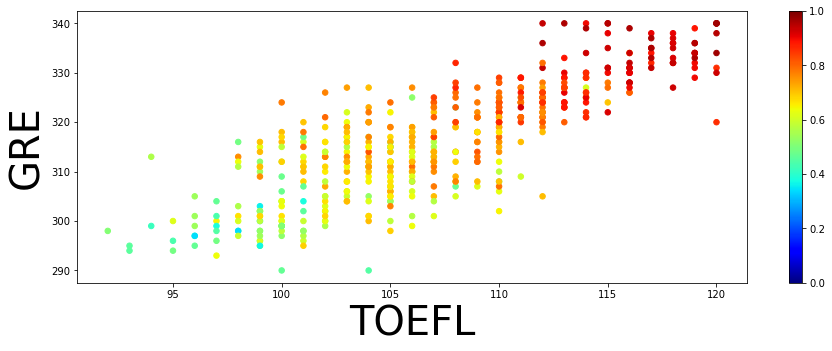

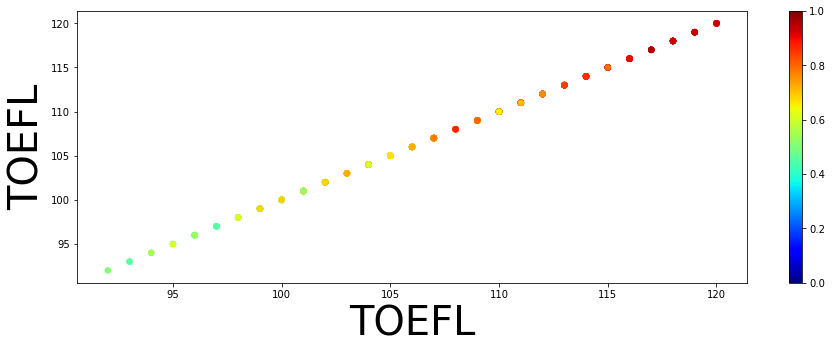

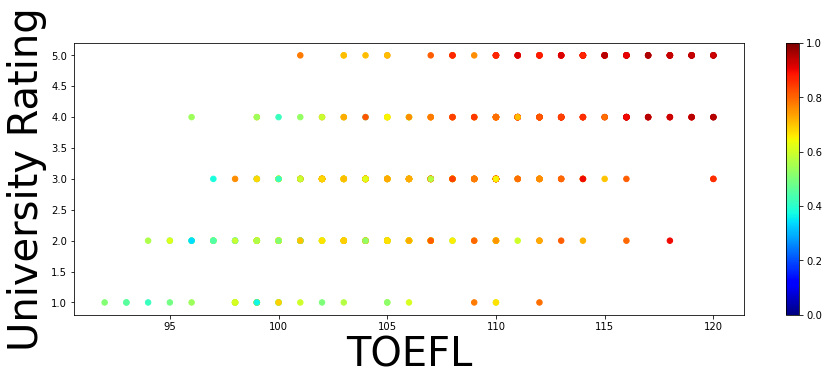

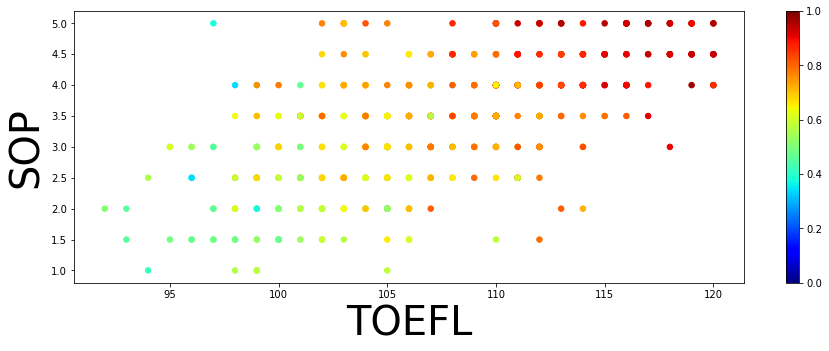

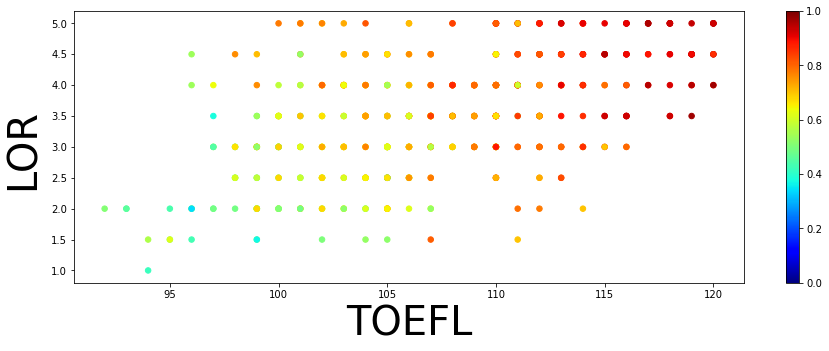

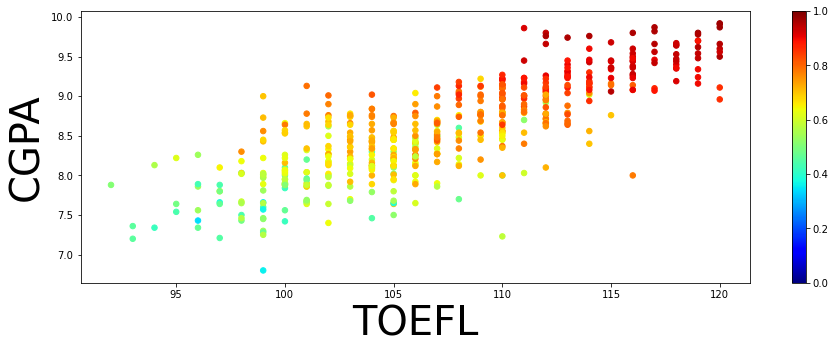

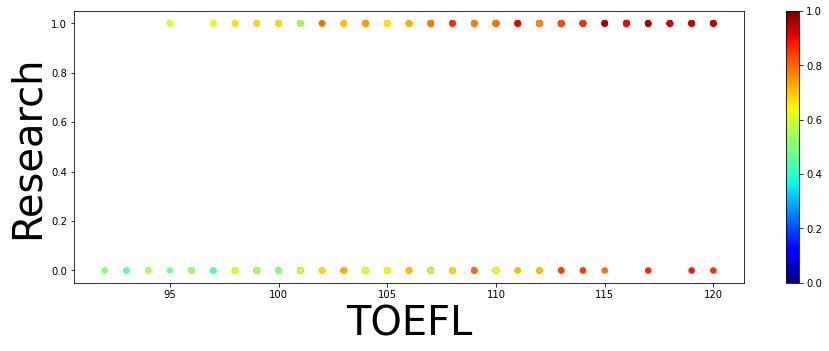

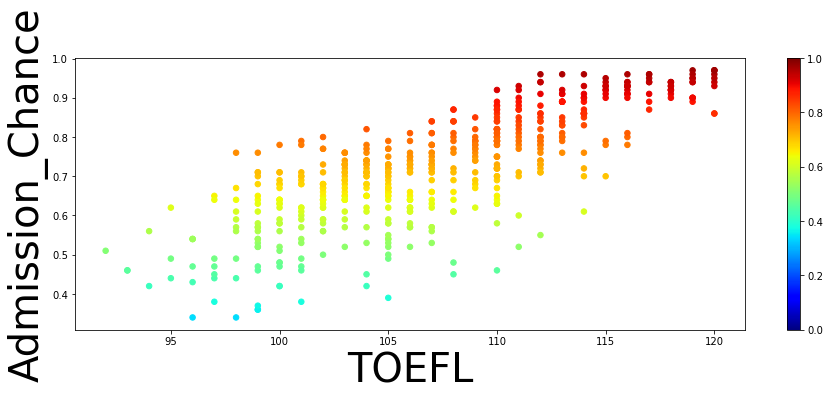

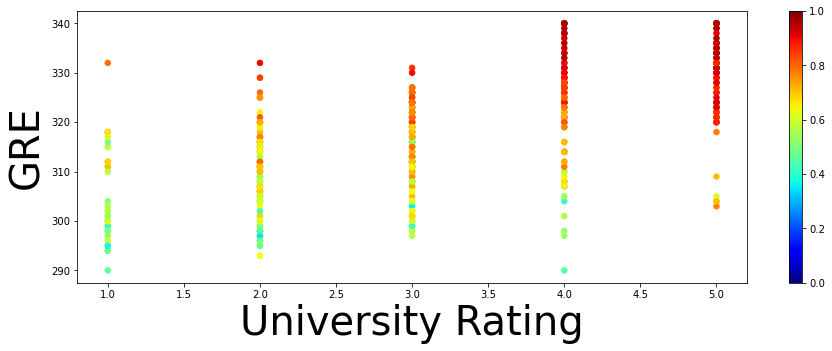

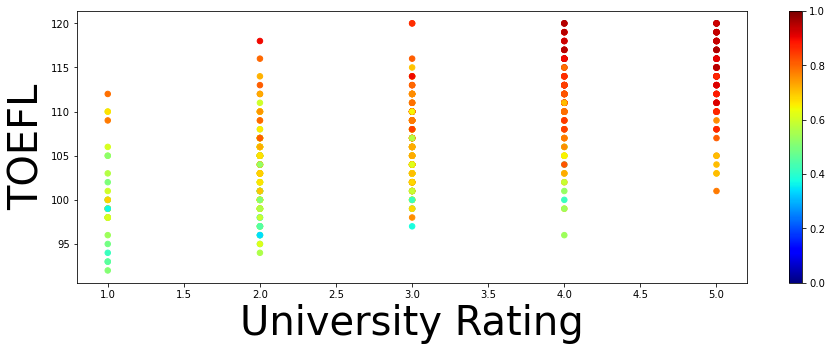

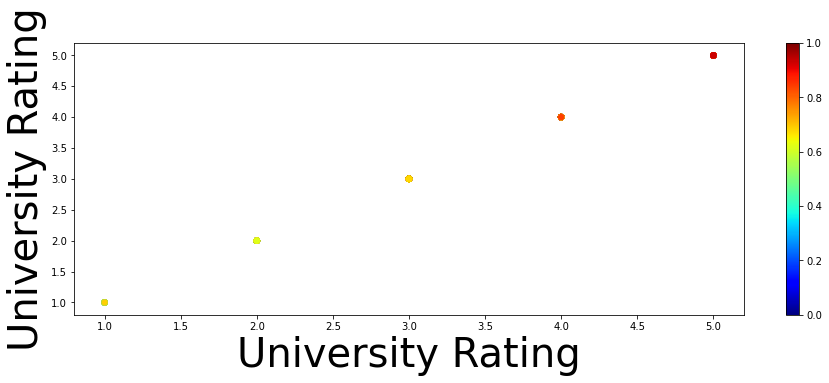

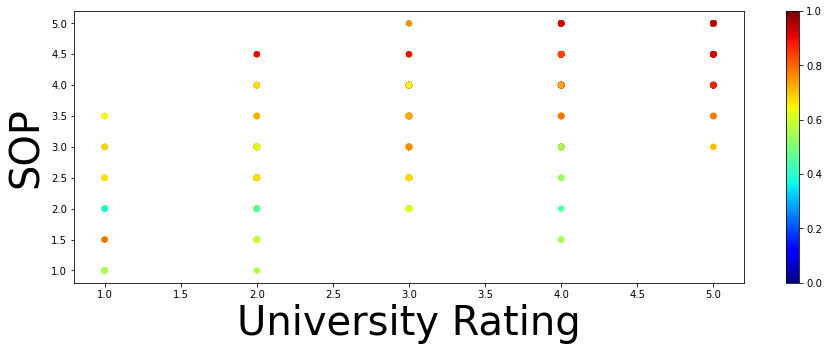

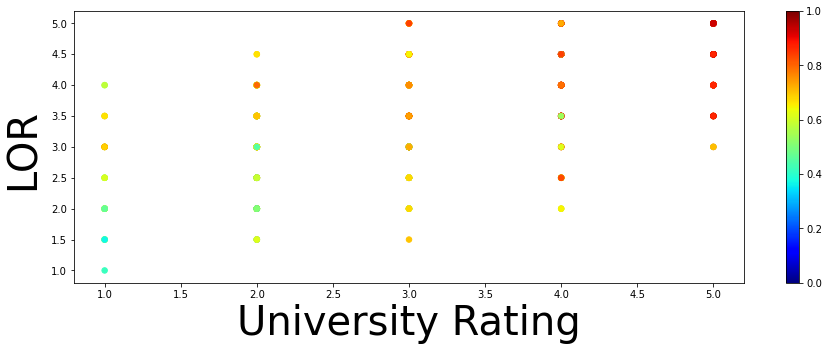

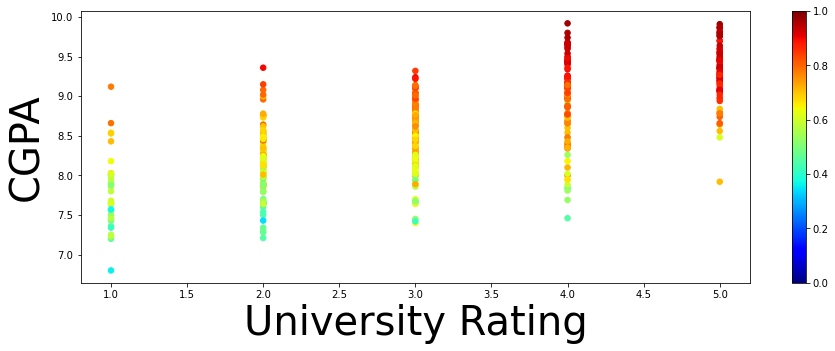

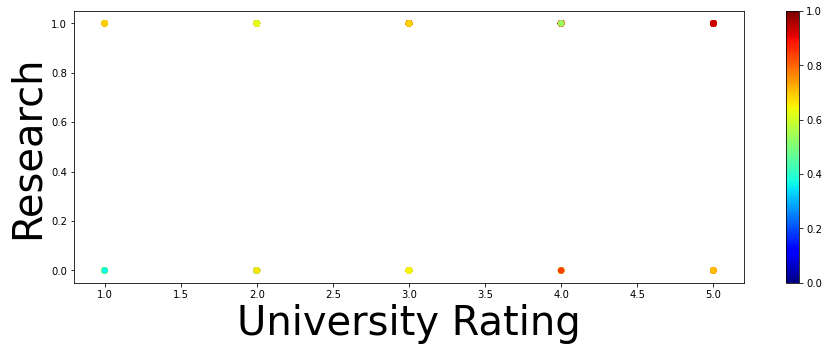

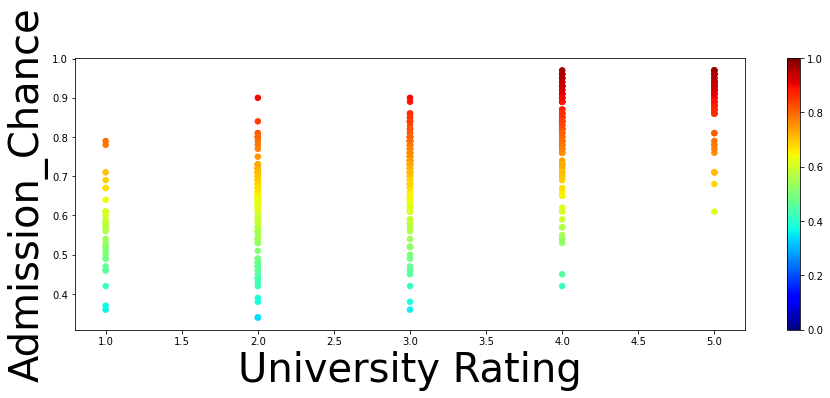

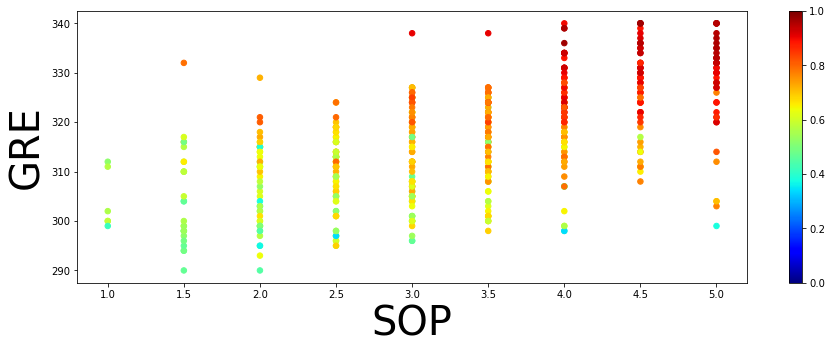

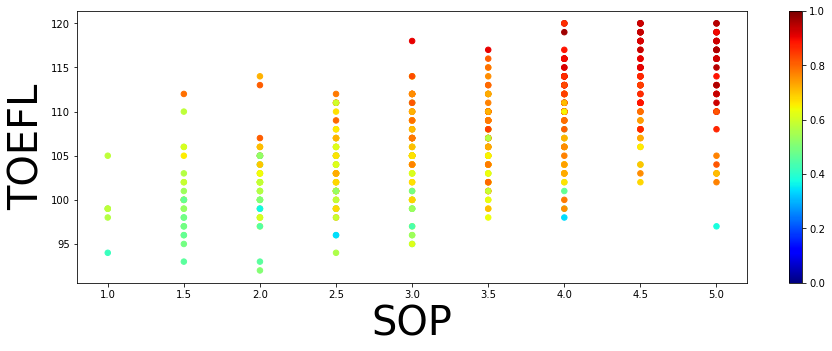

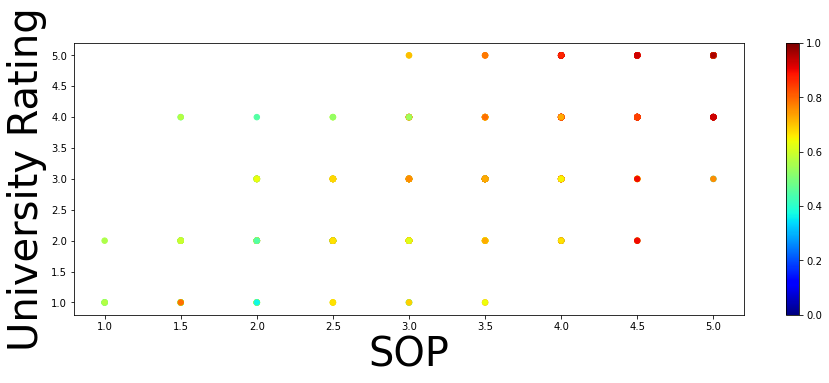

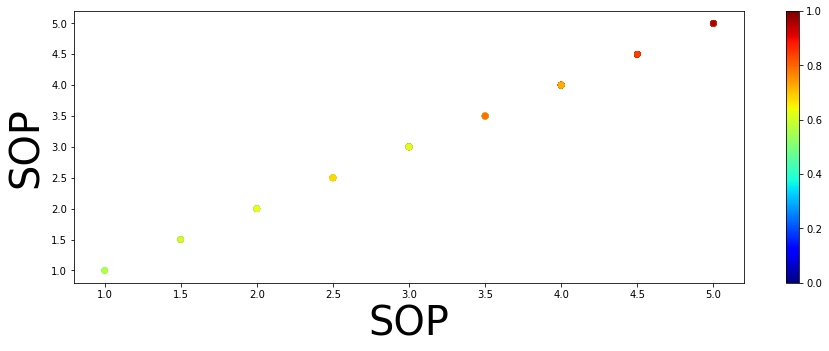

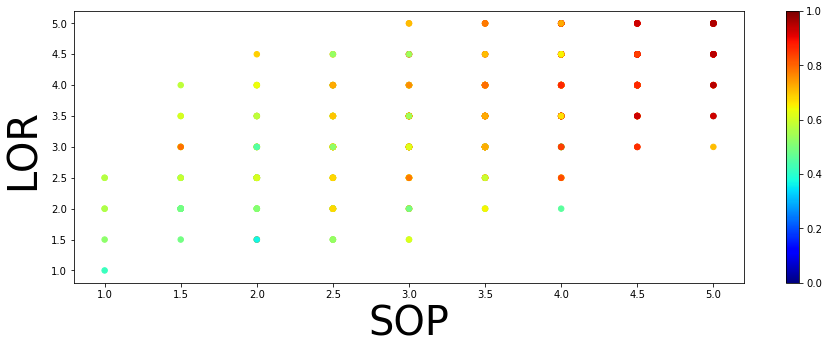

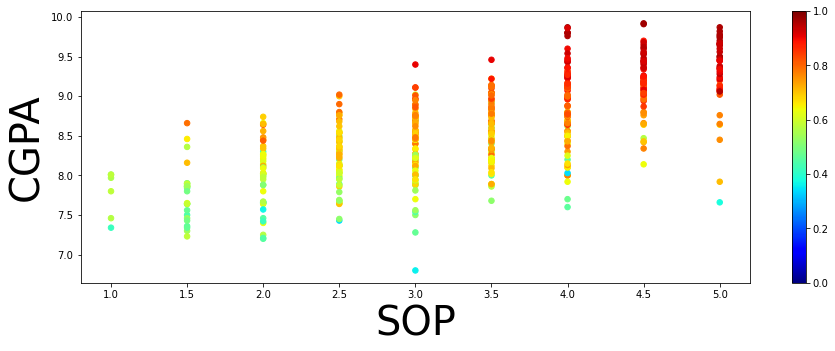

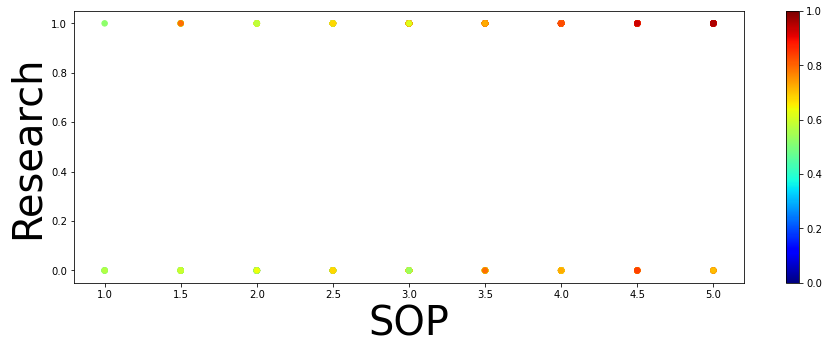

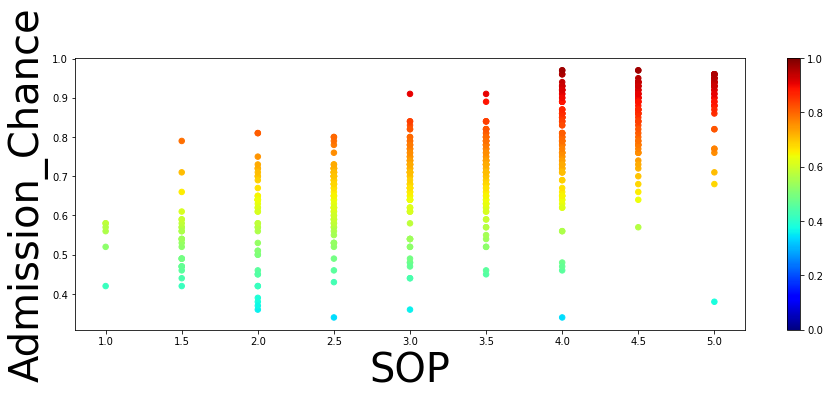

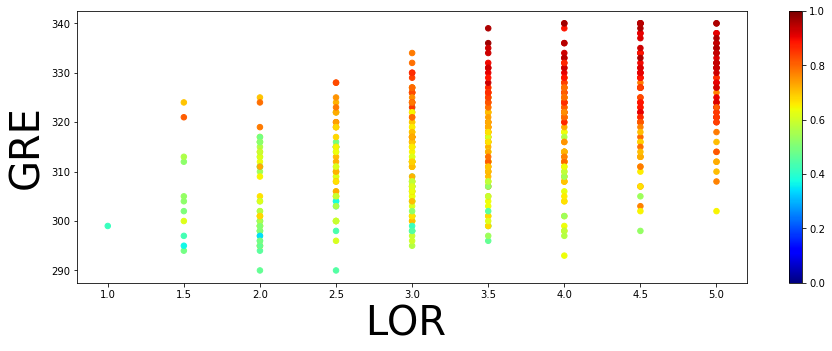

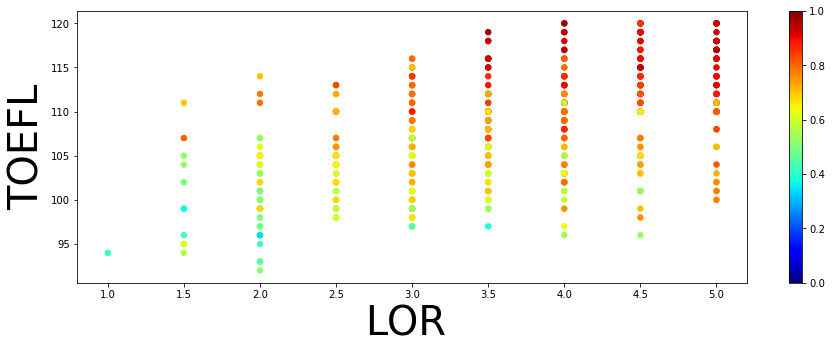

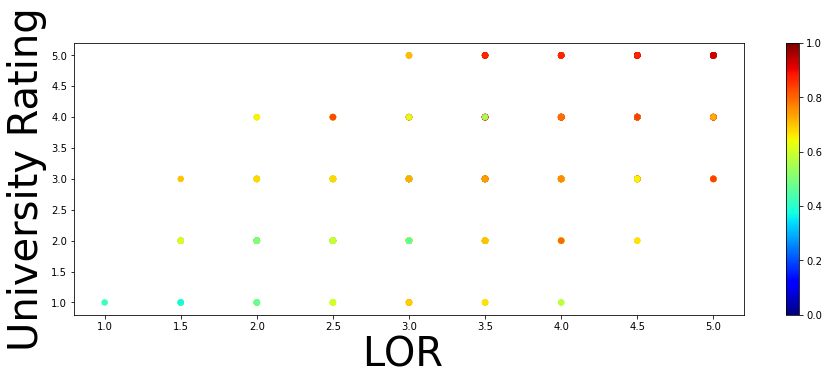

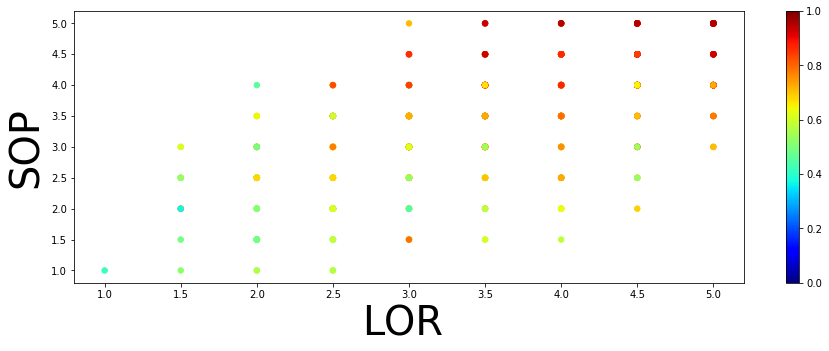

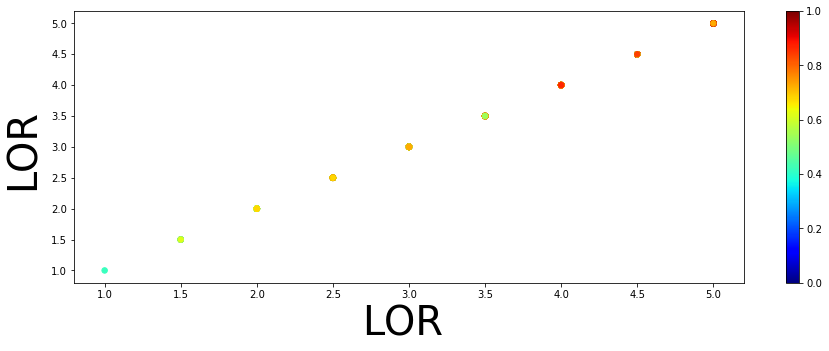

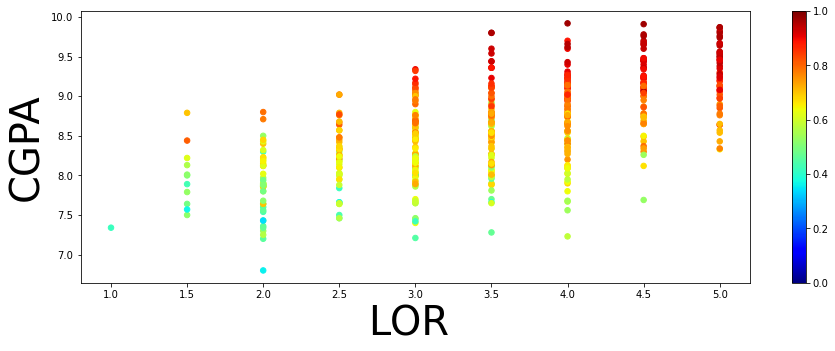

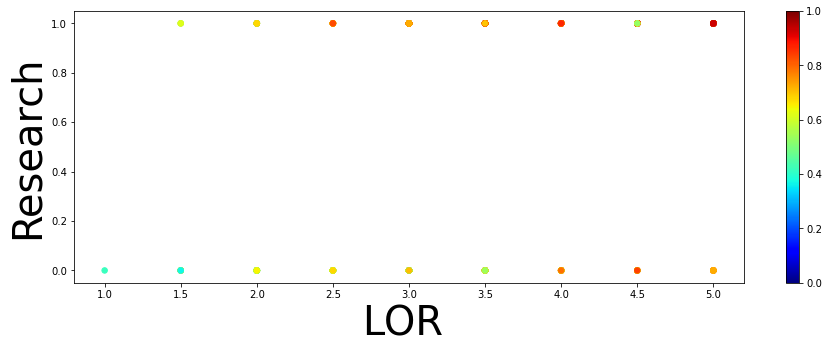

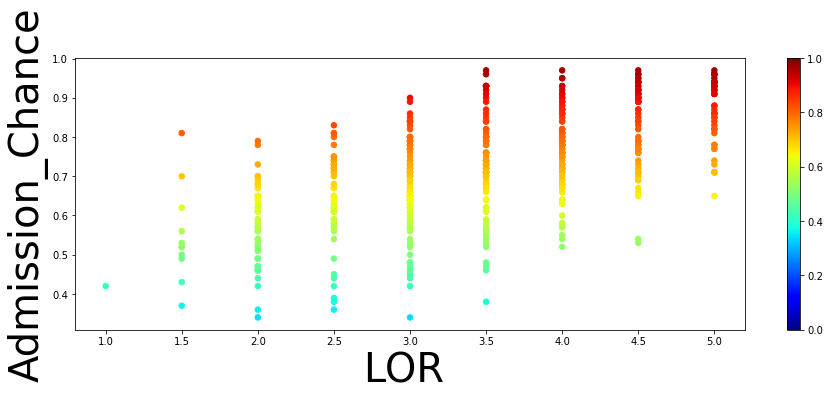

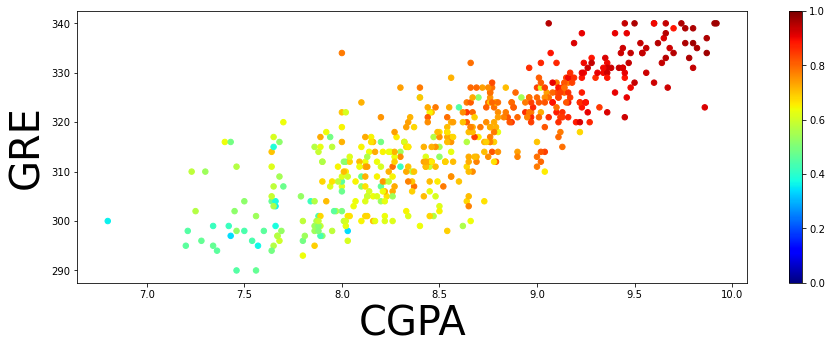

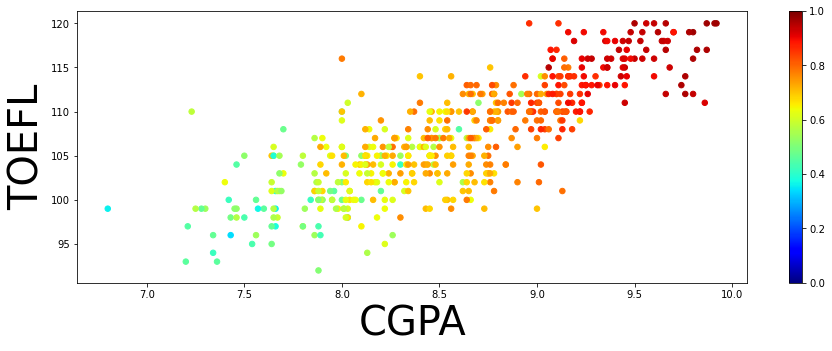

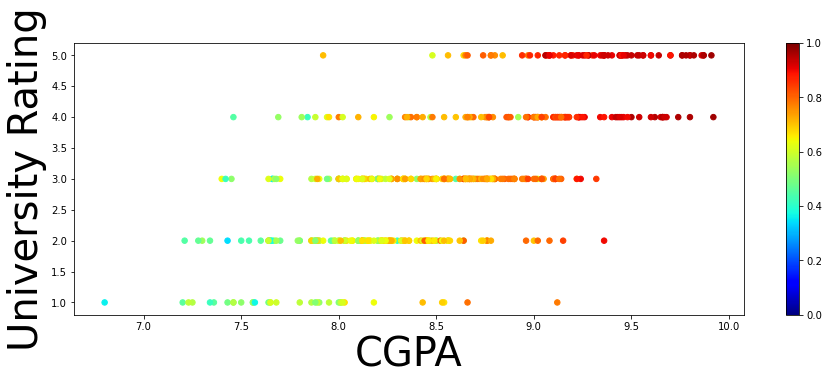

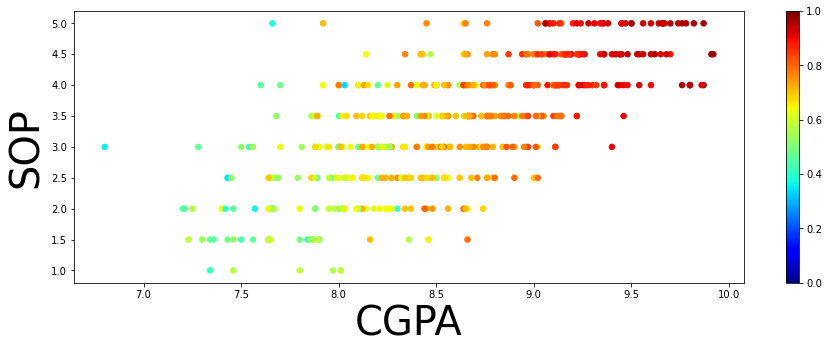

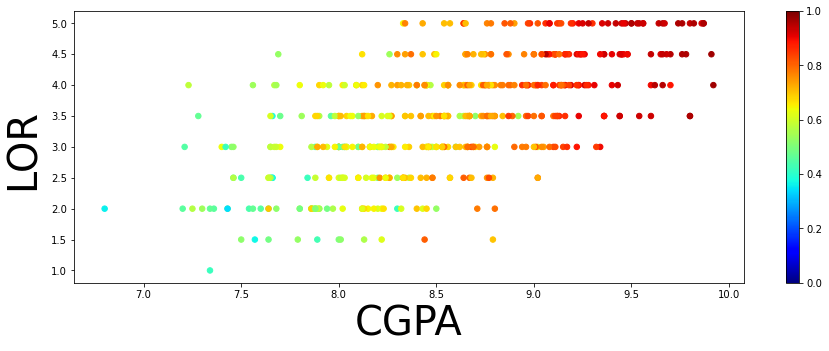

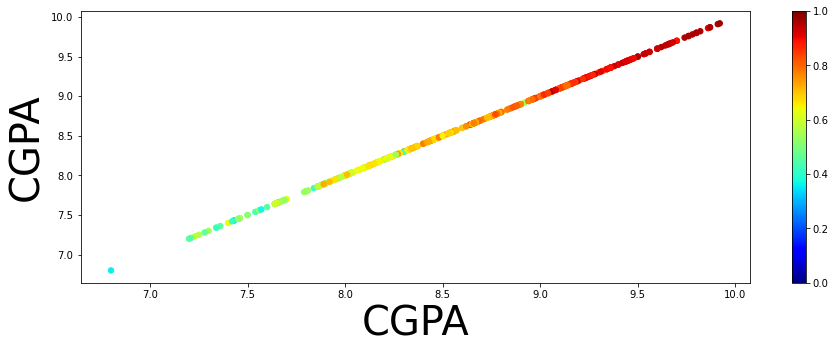

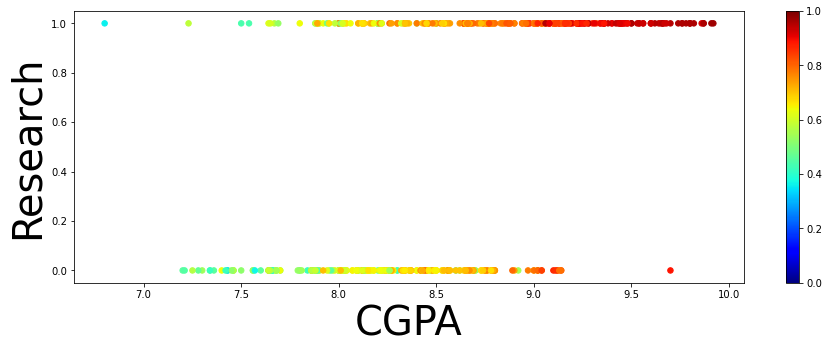

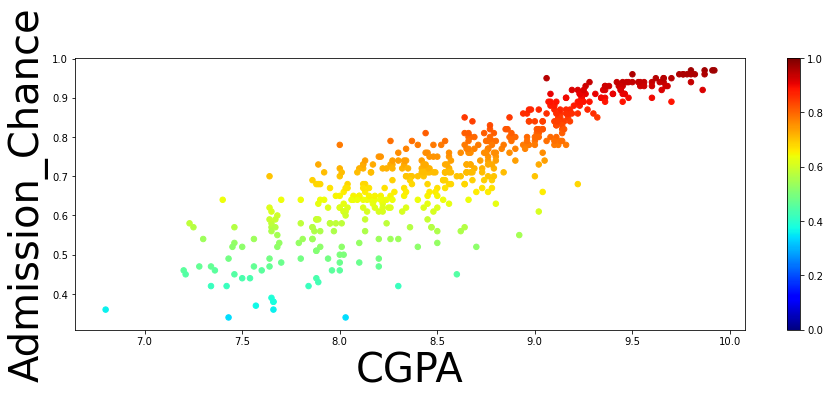

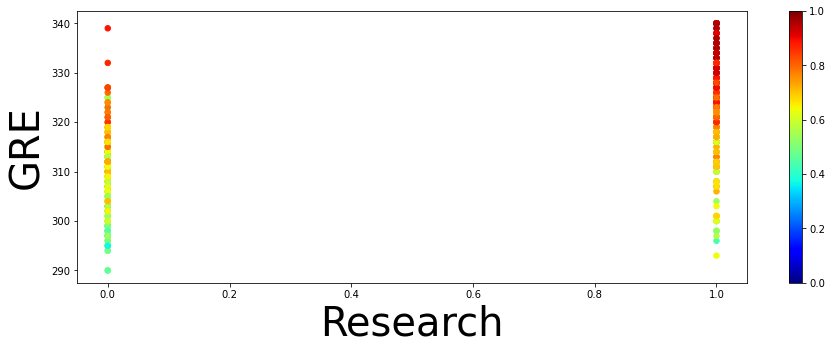

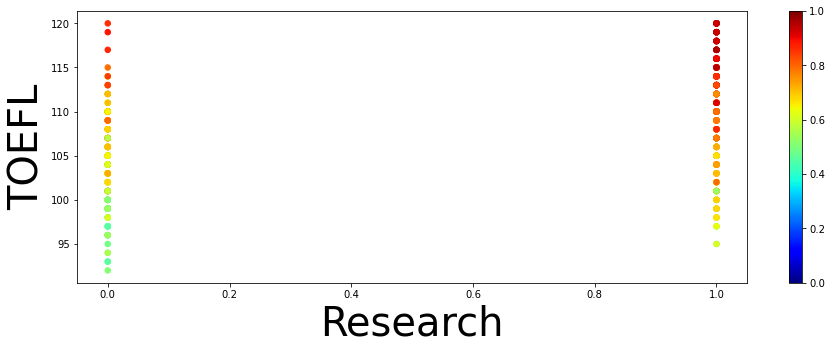

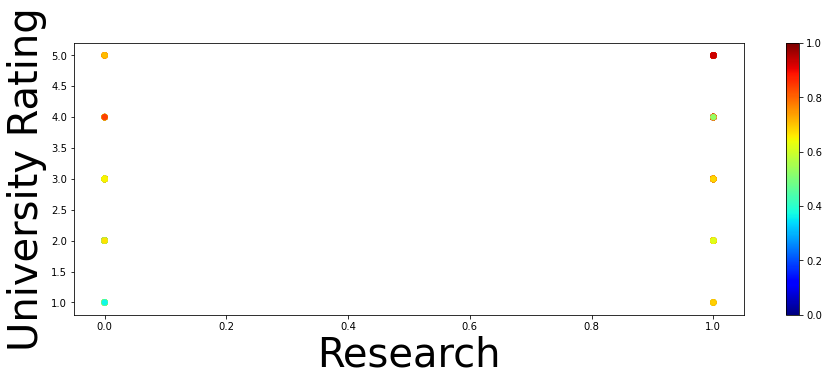

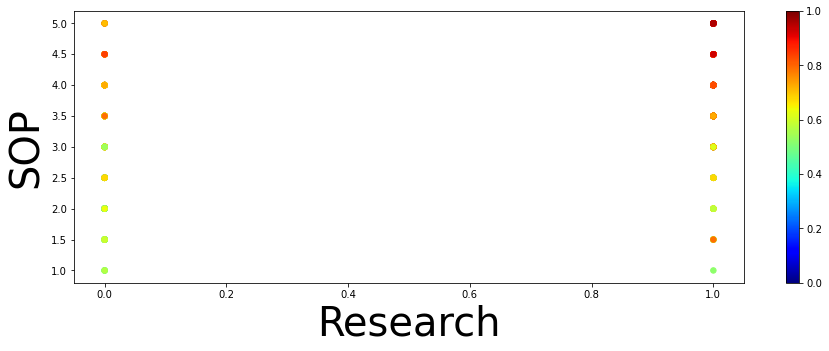

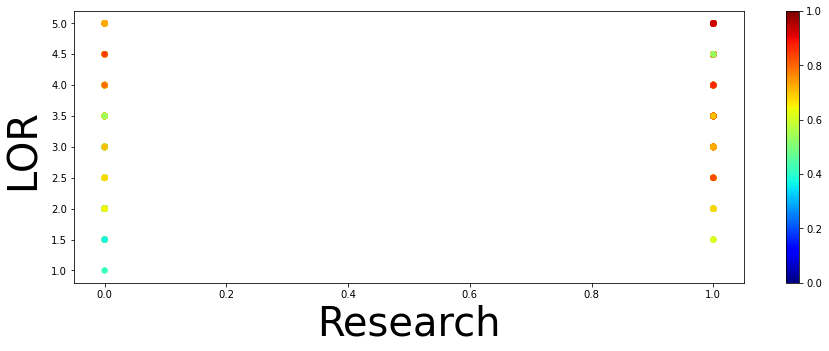

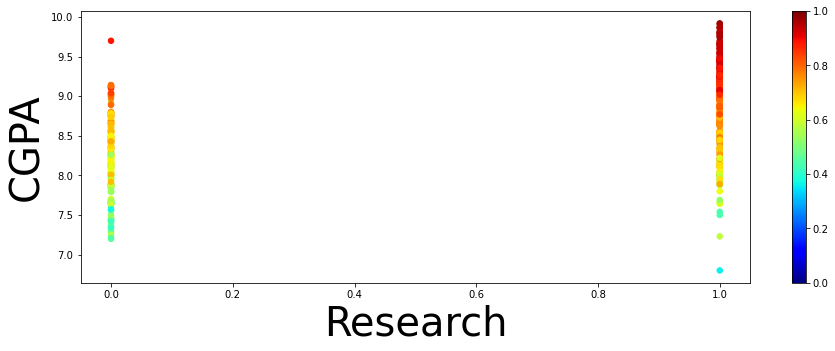

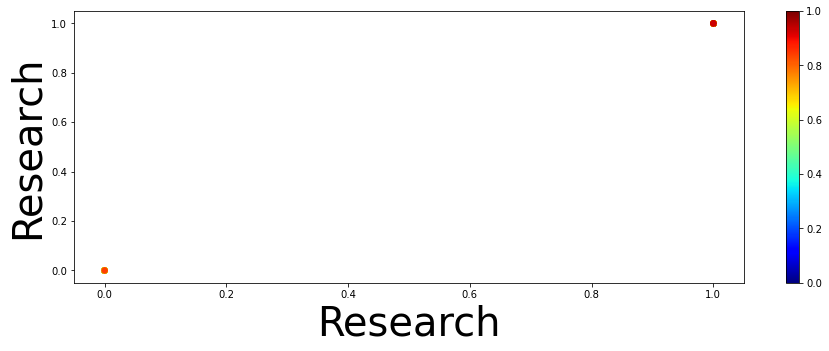

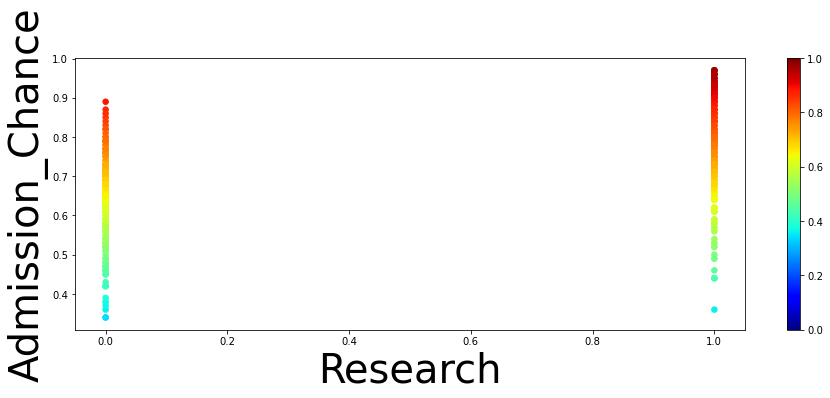

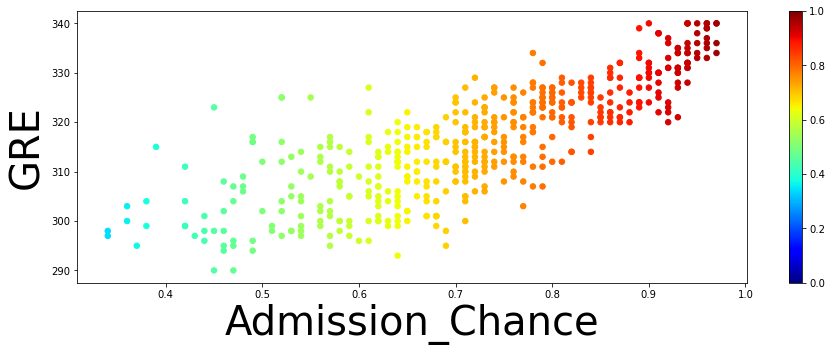

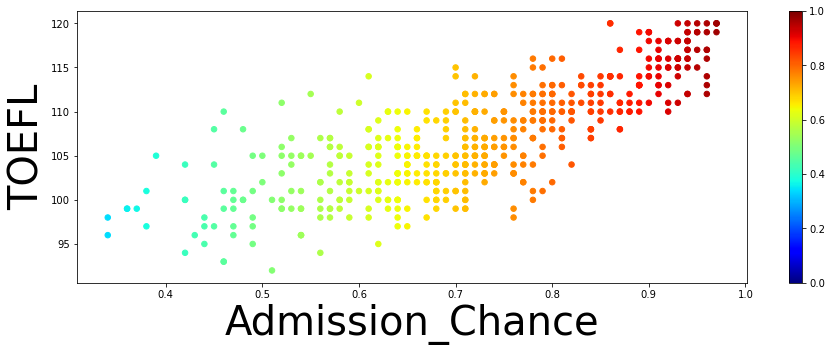

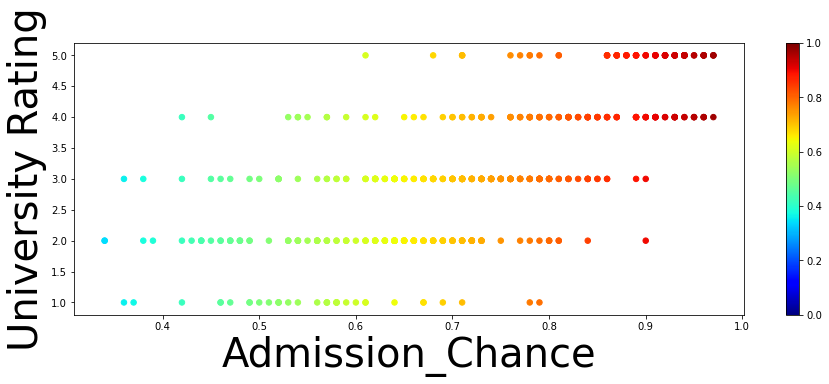

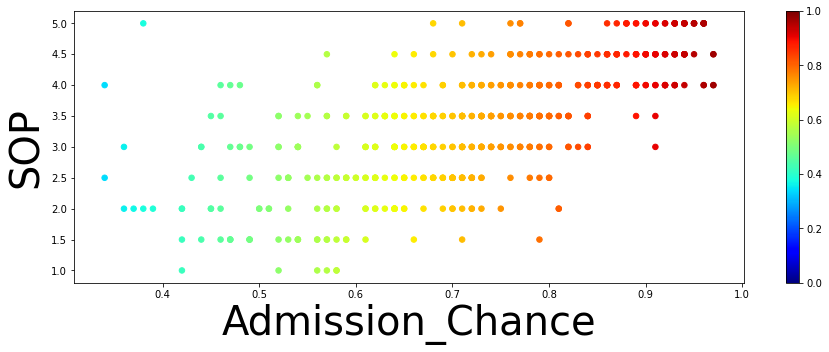

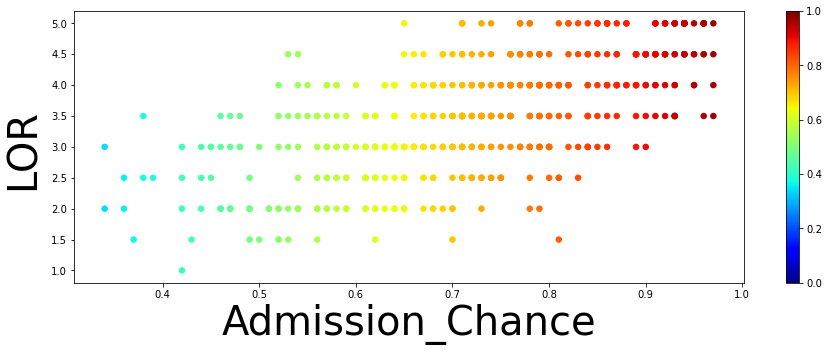

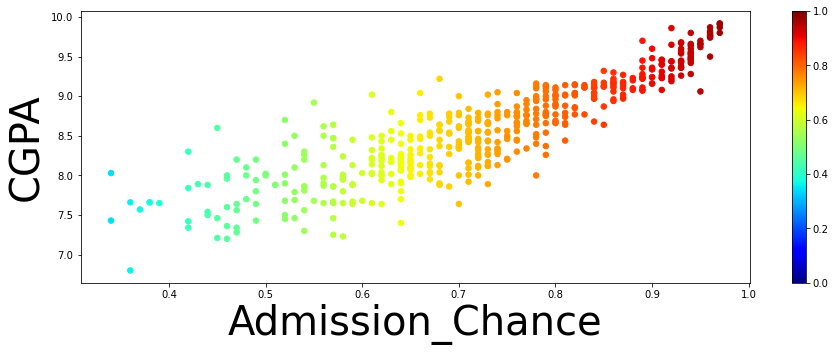

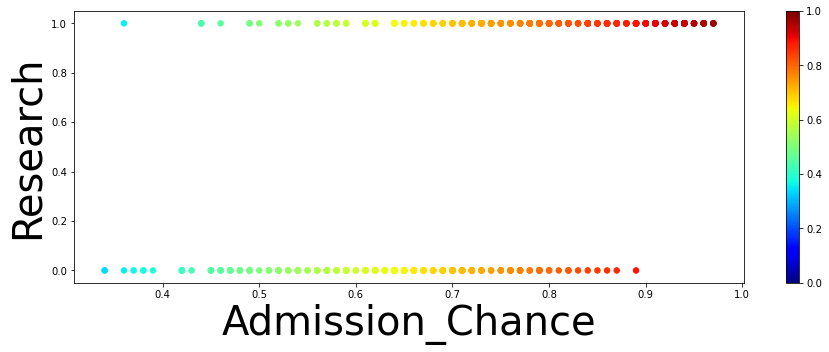

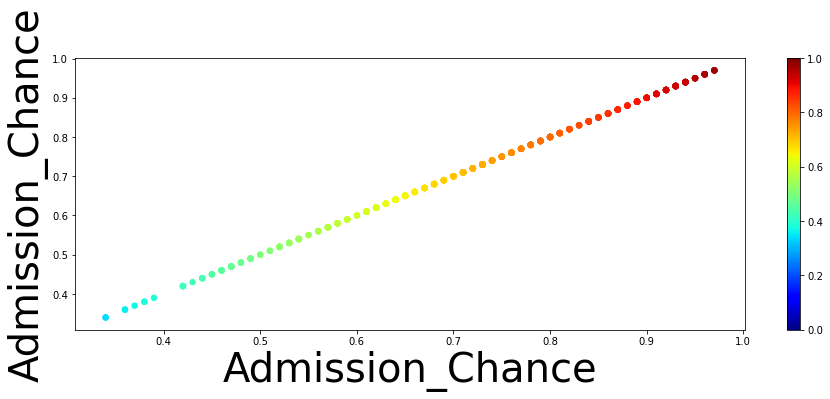

In [50]:
for column_1st in df:
    for coloum_2nd in df:
        jet=plt.get_cmap('jet')
        plt.figure(figsize=(15,5))
        plt.scatter(df[column_1st], df[coloum_2nd], s=30, c=df['Admission_Chance'], vmin=0, vmax=1, cmap=jet)
        plt.xlabel(column_1st,fontsize=40)
        plt.ylabel(coloum_2nd,fontsize=40)
        plt.colorbar()
        plt.show()

In [51]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=7, activation='relu'))
    model.add(Dense(8, input_dim=7, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [52]:
X=np.asarray(df.drop("Admission_Chance",axis=1))
Y=np.asarray(df["Admission_Chance"])

In [53]:
X

array([[337.  , 118.  ,   4.  , ...,   4.5 ,   9.65,   1.  ],
       [324.  , 107.  ,   4.  , ...,   4.5 ,   8.87,   1.  ],
       [316.  , 104.  ,   3.  , ...,   3.5 ,   8.  ,   1.  ],
       ...,
       [330.  , 120.  ,   5.  , ...,   5.  ,   9.56,   1.  ],
       [312.  , 103.  ,   4.  , ...,   5.  ,   8.43,   0.  ],
       [327.  , 113.  ,   4.  , ...,   4.5 ,   9.04,   0.  ]])

In [54]:
Y

array([0.92, 0.76, 0.72, 0.8 , 0.65, 0.9 , 0.75, 0.68, 0.5 , 0.45, 0.52,
       0.84, 0.78, 0.62, 0.61, 0.54, 0.66, 0.65, 0.63, 0.62, 0.64, 0.7 ,
       0.94, 0.95, 0.97, 0.94, 0.76, 0.44, 0.46, 0.54, 0.65, 0.74, 0.91,
       0.9 , 0.94, 0.88, 0.64, 0.58, 0.52, 0.48, 0.46, 0.49, 0.53, 0.87,
       0.91, 0.88, 0.86, 0.89, 0.82, 0.78, 0.76, 0.56, 0.78, 0.72, 0.7 ,
       0.64, 0.64, 0.46, 0.36, 0.42, 0.48, 0.47, 0.54, 0.56, 0.52, 0.55,
       0.61, 0.57, 0.68, 0.78, 0.94, 0.96, 0.93, 0.84, 0.74, 0.72, 0.74,
       0.64, 0.44, 0.46, 0.5 , 0.96, 0.92, 0.92, 0.94, 0.76, 0.72, 0.66,
       0.64, 0.74, 0.64, 0.38, 0.34, 0.44, 0.36, 0.42, 0.48, 0.86, 0.9 ,
       0.79, 0.71, 0.64, 0.62, 0.57, 0.74, 0.69, 0.87, 0.91, 0.93, 0.68,
       0.61, 0.69, 0.62, 0.72, 0.59, 0.66, 0.56, 0.45, 0.47, 0.71, 0.94,
       0.94, 0.57, 0.61, 0.57, 0.64, 0.85, 0.78, 0.84, 0.92, 0.96, 0.77,
       0.71, 0.79, 0.89, 0.82, 0.76, 0.71, 0.8 , 0.78, 0.84, 0.9 , 0.92,
       0.97, 0.8 , 0.81, 0.75, 0.83, 0.96, 0.79, 0.

#### Min-Max Scaler
It essentially shrinks the range such that the range is now between 0 and 1 (or -1 to 1 if there are negative values).

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
     X,Y, test_size=0.2, random_state=0)

from sklearn.preprocessing import MinMaxScaler

scaler =  MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

In [57]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=30, batch_size=3, verbose=1)

**For Checking our Model that it is not General we are using Kfolds**

k-Fold Cross-Validation. Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into.

In [58]:
history=estimator.fit(X_train,y_train)

Epoch 1/30
400/400 [==============================] - 1s 1ms/step - loss: 0.2990
Epoch 2/30
400/400 [==============================] - 0s 668us/step - loss: 0.0071
Epoch 3/30
400/400 [==============================] - 0s 691us/step - loss: 0.0049
Epoch 4/30
400/400 [==============================] - 0s 724us/step - loss: 0.0043
Epoch 5/30
400/400 [==============================] - 0s 762us/step - loss: 0.0040
Epoch 6/30
400/400 [==============================] - 0s 645us/step - loss: 0.0039
Epoch 7/30
400/400 [==============================] - 1s 2ms/step - loss: 0.0038
Epoch 8/30
400/400 [==============================] - 0s 875us/step - loss: 0.0037TA: 0s - loss: 0.
Epoch 9/30
400/400 [==============================] - 0s 756us/step - loss: 0.0037
Epoch 10/30
400/400 [==============================] - 0s 810us/step - loss: 0.0037
Epoch 11/30
400/400 [==============================] - 0s 992us/step - loss: 0.0037
Epoch 12/30
400/400 [==============================] - 0s 836us/step - l

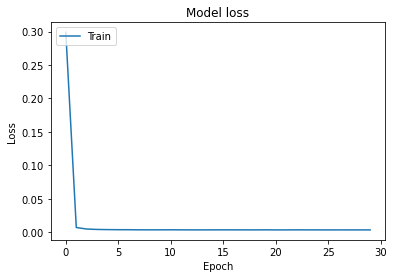

In [59]:
# Plot training & validation loss values
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [60]:
from sklearn.metrics import accuracy_score
prediction = estimator.predict(X_test)

100/100 [==============================] - 0s 1ms/step


In [62]:
train_error =  np.abs(y_test - prediction)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)

In [63]:
print("std_error: ",std_error)
print("mean_error: ",mean_error)
print("min_error: ",min_error)
print("max_error: ",max_error)

std_error:  0.05129179038478931
mean_error:  0.06243575690984724
min_error:  0.0026017379760742143
max_error:  0.24684912204742426


[kfold validation](https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/)

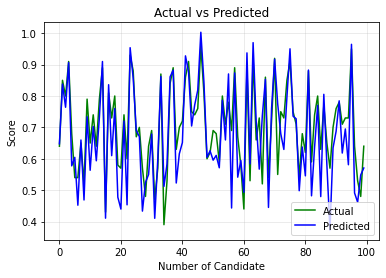

In [64]:
#Visualising the Acutal and predicted Result
plt.plot(y_test, color = 'green', label = 'Actual')
plt.plot(prediction, color = 'blue', label = 'Predicted')
plt.grid(alpha = 0.3)
plt.xlabel('Number of Candidate')
plt.ylabel('Score')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

#### r2 score
In statistics, the coefficient of determination, denoted R² or r² and pronounced "R squared", is the proportion of the variance in the dependent variable that is predictable from the independent variable.



In [65]:
from sklearn.metrics import r2_score
print("r_square score: ", r2_score(y_test,prediction))
print("real value of y_test[1]: " + str(y_test[1]) + " -> the predict: " + str(estimator.predict(X_test[[1],:])))
print("real value of y_test[2]: " + str(y_test[2]) + " -> the predict: " + str(estimator.predict(X_test[[2],:])))

train_prediction = estimator.predict(X_train)
print("r_square score (train dataset): ", r2_score(y_train,train_prediction))

r_square score:  0.6261571736335932
1/1 [==============================] - 0s 3ms/step
real value of y_test[1]: 0.85 -> the predict: [0.83779573]
1/1 [==============================] - 0s 2ms/step
real value of y_test[2]: 0.8 -> the predict: [0.76413405]
400/400 [==============================] - 0s 361us/step
r_square score (train dataset):  0.8189514668915137


#### Mean Absolute Percentage Error
The mean absolute percentage error, also known as mean absolute percentage deviation, is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation, also used as a loss function for regression problems in machine learning.

In [66]:
#from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = (y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [67]:
mean_absolute_percentage_error(y_test, prediction)

9.771500527566987

In [68]:
# Save the weights
estimator.model.save_weights('model_weights.h5')

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(estimator.model.to_json())